In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
from datetime import datetime

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada
gpus= tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True) # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V2 import *
import aux_func_V3 as Modelo1
import aux_func_numpy as debug

# Importando módulo do Weights & Biases para fazer a varredura dos hiper-parâmetros.
import wandb
from wandb.keras import WandbCallback

from IPython.display import clear_output # Definindo a precisão padrão para as análises

float_pres='float64'

In [2]:
# Lendo o conjunto de dados que será utilizado para o treino da rede neural

# Importando o pacote de manipulação de arquivos
import dill

# Lendo os dados
with open('data.bck','rb') as file:
    # Utilizando a CPU como processador
    with tf.device('/device:CPU:0'):
        data_full = dill.load(file)
        data_full = tf.transpose(data_full[0],[1,0,2]).numpy()

In [3]:
# Formatando conjunto de dados para o treino da rede neural
data_x = np.squeeze(data_full[:,:,:-1])
data_y = np.squeeze(data_full[:,:,1:])

data_x = data_x[:,np.arange(100)*4]
data_y = data_y[:,np.arange(100)*4]
data_x = np.concatenate(np.split(data_x, data_x.shape[2], axis=2), axis=0)
data_y = np.concatenate(np.split(data_y, data_y.shape[2], axis=2), axis=0)

indices = np.where(np.sum(data_x**2, axis=1) > 0)[0]
data_x  = data_x[indices]
data_y  = data_y[indices]

# Aleatorizando a ordem dos elementos dos dados
indice = np.arange(data_x.shape[0])
np.random.shuffle(indice)
data_x = data_x.astype(float_pres)[indice]
data_y = data_y.astype(float_pres)[indice]

In [4]:
test_size=5000

# Conjunto de dados de treino
train_x=data_x[:-test_size]
train_y=data_y[:-test_size]

# Conjunto de dados de teste
test_x=data_x[-test_size:]
test_y=data_y[-test_size:]

In [5]:
# Inicializando a configuração padrão de treino.
default_config = wandb.config

default_config.conv_size=5
default_config.regul_ativ=0.09183
default_config.regul_weigth=0.05267
default_config.weigth_OF=0.2995
default_config.usa_reg_ativ=1
default_config.batch_size=512
default_config.deep=1
default_config.learning_rate=0.1
default_config.Model='Modelo 1'
default_config.ativ_func='sigmoid'

# Definindo a configuração da varredura.
sweep_config = {
    'method': 'bayes', # Método de busca.
    'metric': {
      'name': 'val_Inf_Norm', # Métrica alvo.
      'goal': 'minimize'      # Objetivo.
    },
    'parameters': { # Parâmetros a serem modificados e a suas respectivas distribuições à priori.
        'conv_size': {
            'values': [2**i for i in range(5)]
        },
        'Model': {
            'values': ['Modelo 1', 'Modelo 2']
        },
        'regul_ativ': {
            'distribution': 'log_uniform',
            'min': -5.0,
            'max': -1.0
        },
        'usa_reg_ativ': {
            'values':[0.0,1.0]
        },
        'regul_weigth': {
            'distribution': 'log_uniform',
            'min': -5.0,
            'max': -1.0
        },
        'weigth_OF':{
            'distribution': 'uniform',
            'min': 0.0,
            'max': 1.0
        },
        'ativ_func':{
            'values':['sigmoid','elu']
        },
        'deep': {
            'values': [i for i in range(5)]
        },
        'batch_size': {
            'values': [2**i for i in range(6,8)]
        },
        'learning_rate': {
            'distribution': 'log_uniform',
            'min': -5.0,
            'max': -1.0
        }
    }
}

# Criando varredura.
sweep_id = wandb.sweep(sweep_config, project='WENO-DS', entity='silvaneojunior')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 9gdrpcu7
Sweep URL: https://wandb.ai/silvaneojunior/WENO-DS/sweeps/9gdrpcu7


In [6]:
class Burguers_layer(keras.layers.Layer):
    """Criando uma camada de rede neural cuja superclasse é a camada
    do keras para integrar o algoritmo do WENO com a rede neural"""
    def __init__(self, t_final, Δx, CFL, fronteira,config=default_config,float_pres=float_pres):
        """
        Construtor da classe
        --------------------------------------------------------------------------------------
        t_final      (float): tamanho máximo da variação temporal
        Δx           (float): distância espacial dos pontos na malha utilizada
        CFL          (float): constante utilizada para determinar o tamanho da malha temporal
        fronteira (function): função que determina o comportamento do algoritmo na fronteira
        deep           (int): número de camadas de convolução.
        conv_size      (int): número de filtros na convolução.
        regul_weigth (float): peso da regularização.
        --------------------------------------------------------------------------------------
        """
        super(Burguers_layer, self).__init__(dtype=float_pres) # Chamando o inicializador da superclasse

        # Salvando os valores dos parâmetros do construtor no objeto
        self.t_final = tf.Variable(t_final,dtype=float_pres)
        self.Δx = Δx
        self.CFL=CFL
        self.fronteira = fronteira
        self.config=config
        self.float_pres=float_pres
    def build(self, input_shape):
        """
        Função para compor as camadas que constituem essa camada da rede neural
        ------------------------------------------------------------------------
        input_shape : não é utilizado por essa função, mas é um argumento obrigatório para camadas do Keras.
        ------------------------------------------------------------------------
        """
        
        regul_ativ=self.config.usa_reg_ativ*self.config.regul_ativ
        
        if self.config.Model=='Modelo 1' or self.config.ativ_func=='sigmoid':
            # Configuração para a função de ativação sigmoid.
            ativ_func='sigmoid'
            regul_func=lambda x: -regul_ativ*tf.math.reduce_sum(tf.math.log(x))
        else:
            # Configuração para a função de ativação elu+1.
            ativ_func=lambda x: tf.nn.elu(x)+1
            regul_func=lambda x: regul_ativ*tf.math.reduce_sum((x-1)**2)
        
        self.layers=[]
        wei_reg=tf.keras.regularizers.L2(self.config.regul_weigth)
        for i in range(self.config.deep):
            self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))
            self.layers.append(keras.layers.Conv1D(self.config.conv_size,5,activation='elu',dtype=self.float_pres,kernel_regularizer=wei_reg))
        if self.config.Model!='Modelo 1':
            self.layers.append(keras.layers.Conv1D(1,1,activation=ativ_func,dtype=self.float_pres,kernel_regularizer=wei_reg,activity_regularizer=regul_func))
        else:
            self.layers.append(keras.layers.Conv1D(1,1,activation=ativ_func,dtype=self.float_pres,kernel_regularizer=wei_reg,activity_regularizer=regul_func))

    def get_config(self):
        """
        Função utilizada para recuperar a configuração da camada (para futura recriação).
        ----------------------------------------------------------------------
        Não tem entradas
        ----------------------------------------------------------------------
        config (dict): Dicionário com a configuração da camada.
        ----------------------------------------------------------------------
        """
        config = super(Burguers_layer, self).get_config()
        
        config['conv_size']=self.config.conv_size
        config['regul_ativ']=self.config.regul_ativ
        config['regul_weigth']=self.config.regul_weigth
        config['weigth_OF']=self.config.weigth_OF
        config['usa_reg_ativ']=self.config.usa_reg_ativ
        config['batch_size']=self.config.batch_size
        config['deep']=self.config.deep
        config['learning_rate']=self.config.learning_rate
        config['Model']=self.config.Model
        config['ativ_func']=self.config.ativ_func
        
        config.update({'t_final':self.t_final.numpy(),
                       'Δx':self.Δx,
                       'CFL':self.CFL,
                       'fronteira':self.fronteira,
                       'float_pres':self.float_pres})
        return config
    @classmethod
    def from_config(self, config):
        """
        Função utilizada reconstruir a camada a partir da configuração.
        ----------------------------------------------------------------------
        config (dict): Dicionário com a configuração da camada.
        ----------------------------------------------------------------------
        Objeto da classe Burguers_layer criado com a configuração escolhida.
        ----------------------------------------------------------------------
        """
        placeholder={}
        
        placeholder['conv_size']=config.conv_size
        placeholder['regul_ativ']=config.regul_ativ
        placeholder['regul_weigth']=config.regul_weigth
        placeholder['weigth_OF']=config.weigth_OF
        placeholder['usa_reg_ativ']=config.usa_reg_ativ
        placeholder['batch_size']=config.batch_size
        placeholder['deep']=config.deep
        placeholder['learning_rate']=config.learning_rate
        placeholder['Model']=config.Model
        placeholder['ativ_func']=config.ativ_func
        
        return self(t_final=config.t_final,
                    Δx=config.Δx,
                    CFL=config.CFL,
                    fronteira=config.fronteira,
                    float_pres=config.float_pres,
                    config=placeholder
                   )

    def network_graph(self,x):
        """
        Função utilizado para executar sucessivamente as camadas dessa camada 
        da rede neural, passando o input de uma para a próxima
        ----------------------------------------------------------------------
        x (tensor): valor de entrada da rede
        ----------------------------------------------------------------------
        y (tensor): valor de saída da rede
        ----------------------------------------------------------------------
        """
        y=x
        for layer in self.layers:
            y=layer(y)
        return y

    def call(self, inpt,mask=None):
        """
        Função utilizada para treino que recebe o input da camada e computa o output
        -----------------------------------------------------------------------------
        inpt  (tensor): input passado para a camada
        mask       (?): não é utilizado por essa função
        -----------------------------------------------------------------------------
        outpt (tensor): output retorna pela camada
        -----------------------------------------------------------------------------
        """
        Λ  = tf.math.reduce_max(tf.abs(inpt)) # Valor utilizado para obter o Δt
        Δt = self.Δx*self.CFL/Λ               # Obtendo o valor de Δt a partir de CFL
        # Caso o passo temporal utrapasse o valor de t_final
        # então o tamanho do passo se torna o tempo que 
        # falta para se obter o t_final
        Δt = tf.where(Δt > self.t_final, self.t_final, Δt)

        if self.config.Model!='Modelo 1':
            # Grafo do WENO-Z para o Modelo 2
            return Graph_Burgers(u=inpt, Δt=Δt, Δx=self.Δx, fronteira=self.fronteira,network=self.network_graph)
        else:
            # Grafo do WENO-Z para o Modelo 1
            return Modelo1.Graph_Burgers(u=inpt, Δt=Δt, Δx=self.Δx, fronteira=self.fronteira,network=self.network_graph)
    def predict(self, inputs,mask=None):
        """Função que faz previsão a partir de um input"""
        return self(inputs,mask=None) # Chamando o função call (self.predict(inputs, mask) = self.call(inpt, mask))

In [7]:
def Inf_Norm(y_true, y_pred):
    """
    Função que recebe dois tensors contendo valores reais e retorna a Norma infinita da diferença entre eles.
    -------------------------------------------------------------------------------------------
    y_true       (tensor): valores de referência do conjunto de dados.
    y_pred       (float): valores de previstos pela rede.
    -------------------------------------------------------------------------------------------
    error        (tensor): Erro de previsão na Norma infinita.
    -------------------------------------------------------------------------------------------
    """
    y_true = tf.cast(y_true, y_pred.dtype)
    error=tf.reduce_max(tf.math.abs(y_pred - y_true), axis=-1)
    return error

class WandBLog(tf.keras.callbacks.Callback):
    def __init__(self,network):
        self.Network=network
    def on_epoch_end(self, *logs):
        # Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
        # como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
        # modificação da rede neural numa malha mais grossa
        Δx = 0.04                                  # Distância espacial dos pontos na malha mais grossa utilizada
        x  = tf.range(-2, 2, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

        full_U   = test_x[-500:] # 500 últimos dados de entrada do conjunto de treino
        ref_full = test_y[-500:] # 500 últimos dados de saída do conjunto de treino

        CFL    = 0.5  # Constante utilizada para determinar o tamanho da malha temporal
        Δt_max = 0.01 # Instante de tempo final
        t      = 0.0  # Instante de tempo inicial

        # Valor utilizado para obter o Δt
        Λ = tf.math.reduce_max(tf.abs(full_U), axis=1, keepdims=True)
        # Obtendo o valor de Δt a partir de CFL
        Δt = Δx*CFL/Λ
        # Caso o passo temporal utrapasse o valor de Δt_max então o 
        # tamanho do passo se torna Δt_max
        Δt = tf.where(Δt > Δt_max, Δt_max, Δt)

        net_u   = tf.squeeze(self.Network.predict(full_U))             # Previsão com o WENO-Z modificado pela rede neural
        debug_u = Burgers(full_U,Δt, Δx, CFL, FronteiraPeriodica) # Previsão com o WENO-Z

        # Armazenando ambos os erros de previsão
        error = tf.stack([tf.squeeze(net_u)-tf.squeeze(ref_full),tf.squeeze(tf.squeeze(debug_u)-tf.squeeze(ref_full))],axis=0)

        # Erro médio na norma L2
        desv_error_MSE=tf.math.reduce_mean((tf.math.reduce_sum(error**2,axis=1)**0.5)/error.shape[1],axis=1)
        # Erro médio na norma do infinito
        desv_error_Inf=tf.math.reduce_max(tf.math.reduce_max(tf.math.abs(error),axis=1),axis=1)

        #Passando os erros para o Weigths and Biases.
        wandb.log({"Depara_MSE": (desv_error_MSE[0]/desv_error_MSE[1]),
                   "Depara_Inf": (desv_error_Inf[0]/desv_error_Inf[1])})

def train():
    """
    Função que realiza o treino da rede neural para um conjunto de hiper-parâmetros
    -------------------------------------------------------------------------------------------
    Sem argumentos
    -------------------------------------------------------------------------------------------
    Sem output
    -------------------------------------------------------------------------------------------
    """
    clear_output() # Limpa o output da célula (exclusivo para o Jupyter)
    run=wandb.init() # Inicializando o treino da rede. Nesta etapa o wandb amostrará um conjunto de hipe-parâmetros segundo a distribuição à posterior.
    config=wandb.config # Armazenando a configuração amostrada.
    
    # Definindo callbacks.
    # Cada função da lista a seguir será executada ao final de cada epoch.
    
    # Definindo o input da rede e o otimizador de treino
    input_x=keras.layers.Input([100,1],dtype='float64')
    optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    
    # Criando uma camada de Burgers que integra o WENO à rede neural
    final_layer=Burguers_layer(t_final=0.01,Δx=0.04,CFL=0.5,fronteira=FronteiraPeriodica,config=config,float_pres=float_pres)

    class MES_OF(tf.keras.losses.Loss):
        """Criando uma função de custo cuja superclasse é a de funções de
        custo do keras"""
        def call(self, y_true, y_pred):
            """
            Função que avalia o custo dado um valor de referência e um valor previsto
            --------------------------------------------------------------------------
            y_true (tensor): valor de referência
            y_pred (tensor): valor predito
            --------------------------------------------------------------------------
            loss   (tensor): custo associado
            --------------------------------------------------------------------------
            """
            y_true = tf.cast(y_true, y_pred.dtype) # Convertendo os tipos para evitar conflitos
            y_min  = tf.math.reduce_min(y_true,axis=1,keepdims=True)
            y_max  = tf.math.reduce_max(y_true,axis=1,keepdims=True)
            
            # Custo por erro na norma L2
            loss_MSE=tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
            
            # Custo por previsão 'muito alta'
            loss_sup=tf.where(y_pred > y_max, y_pred - y_max,  0)
            # Custo por previsão 'muito baixa'   
            loss_inf=tf.where(y_pred < y_min, y_min  - y_pred, 0)
            
            loss_OF=tf.reduce_sum(loss_sup+loss_inf,axis=-1)
            loss = (1-config.weigth_OF)*loss_MSE + config.weigth_OF*loss_OF
            return loss
        
    # Criando a rede neural
    Network=keras.Model(input_x, final_layer(input_x))
    # Configurando a função de perda e o otimizador
    Network.compile(loss=MES_OF(),optimizer=optimizer,metrics=[Inf_Norm,'mean_absolute_error'])
    
    callback = [WandbCallback(),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),WandBLog(Network)]
    # Treinando a rede neural
    loss=Network.fit(train_x                                        , # Dados de treino
                     train_y                                        , # Dados de treino
                     validation_data = (test_x, test_y)             , # Dados de validação
                     batch_size      = config.batch_size            , # Tamanho do batch
                     epochs          = int(3/config.learning_rate)  , # Número de epochs
                     steps_per_epoch = 30                           , # Número de batchs por epoch
                     shuffle         = True                         , # Aleatorização dos batchs
                     callbacks=callback                            ) # Funções a serem executadas no final de cada Epoch
        
    Network.save('Modelo_teste_{0}_{1}'.format(desv_error_MSE[0]/desv_error_MSE[1],datetime.now()))
    
    return Network

In [9]:
# Como salvar e carregar modelos

#Network.save('NOME')
#Network=tf.keras.models.load_model('NOME', custom_objects={"Burguers_layer": Burguers_layer})

In [ ]:
# Executando a varredura.
wandb.agent(sweep_id, train)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: silvaneojunior (use `wandb login --relogin` to force relogin)


Epoch 1/296
30/30 [==============================] - 37s 822ms/step - loss: 65.8640 - Inf_Norm: 0.0047 - mean_absolute_error: 0.0047 - val_loss: 51.9616 - val_Inf_Norm: 0.0045 - val_mean_absolute_error: 0.0045
Epoch 2/296
30/30 [==============================] - 22s 739ms/step - loss: 39.0737 - Inf_Norm: 0.0046 - mean_absolute_error: 0.0046 - val_loss: 27.5008 - val_Inf_Norm: 0.0043 - val_mean_absolute_error: 0.0043
Epoch 3/296
30/30 [==============================] - 22s 745ms/step - loss: 20.7299 - Inf_Norm: 0.0040 - mean_absolute_error: 0.0040 - val_loss: 15.0224 - val_Inf_Norm: 0.0043 - val_mean_absolute_error: 0.0043
Epoch 4/296
30/30 [==============================] - 21s 705ms/step - loss: 11.5325 - Inf_Norm: 0.0042 - mean_absolute_error: 0.0042 - val_loss: 8.4504 - val_Inf_Norm: 0.0042 - val_mean_absolute_error: 0.0042
Epoch 5/296
30/30 [==============================] - 21s 723ms/step - loss: 6.4858 - Inf_Norm: 0.0044 - mean_absolute_error: 0.0044 - val_loss: 4.7533 - val_Inf_

In [ ]:
clear_output() # Limpa o output da célula (exclusivo para o Jupyter)
run=wandb.init(config=default_config) # Inicializando o treino da rede. Nesta etapa o wandb amostrará um conjunto de hipe-parâmetros segundo a distribuição à posterior.
config=wandb.config # Armazenando a configuração amostrada.

# Definindo callbacks.
# Cada função da lista a seguir será executada ao final de cada epoch.
callback = [WandbCallback(),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]

# Definindo o input da rede e o otimizador de treino
input_x=keras.layers.Input([100,1],dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando uma camada de Burgers que integra o WENO à rede 
final_layer=Burguers_layer(t_final=0.1,Δx=0.02,CFL=0.5,fronteira=FronteiraPeriodica,config=config,float_pres=float_pres)

class MES_OF(tf.keras.losses.Loss):
    """Criando uma função de custo cuja superclasse é a de funções de
    custo do keras"""
    def call(self, y_true, y_pred):
        """
        Função que avalia o custo dado um valor de referência e um valor previsto
        --------------------------------------------------------------------------
        y_true (tensor): valor de referência
        y_pred (tensor): valor predito
        --------------------------------------------------------------------------
        loss   (tensor): custo associado
        --------------------------------------------------------------------------
        """
        y_true = tf.cast(y_true, y_pred.dtype) # Convertendo os tipos para evitar conflitos
        y_min  = tf.math.reduce_min(y_true,axis=1,keepdims=True)
        y_max  = tf.math.reduce_max(y_true,axis=1,keepdims=True)

        # Custo por erro na norma L2
        loss_MSE=tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)

        # Custo por previsão 'muito alta'
        loss_sup=tf.where(y_pred > y_max, y_pred - y_max,  0)
        # Custo por previsão 'muito baixa'   
        loss_inf=tf.where(y_pred < y_min, y_min  - y_pred, 0)

        loss_OF=tf.reduce_sum(loss_sup+loss_inf,axis=-1)
        loss = (1-config.weigth_OF)*loss_MSE + config.weigth_OF*loss_OF
        return loss

# Criando a rede neural
Network=keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss=MES_OF(),optimizer=optimizer,metrics=[Inf_Norm,'mean_absolute_error'])

# Treinando a rede neural
loss=Network.fit(train_x                                        , # Dados de treino
                 train_y                                        , # Dados de treino
                 validation_data = (test_x, test_y)             , # Dados de validação
                 batch_size      = config.batch_size            , # Tamanho do batch
                 epochs          = int(3/config.learning_rate)  , # Número de epochs
                 steps_per_epoch = 30                           , # Número de batchs por epoch
                 shuffle         = True                         , # Aleatorização dos batchs
                 callbacks=callback)

In [79]:
Δt.shape

TensorShape([1, 1, 1])

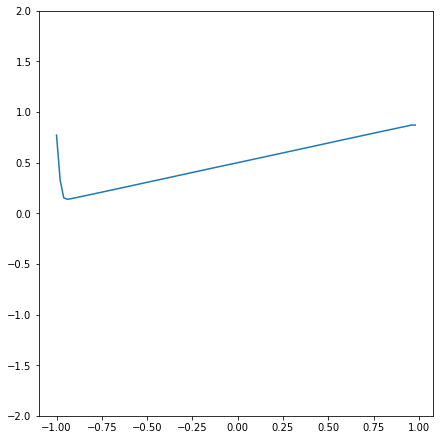

t:  2.0                                                  



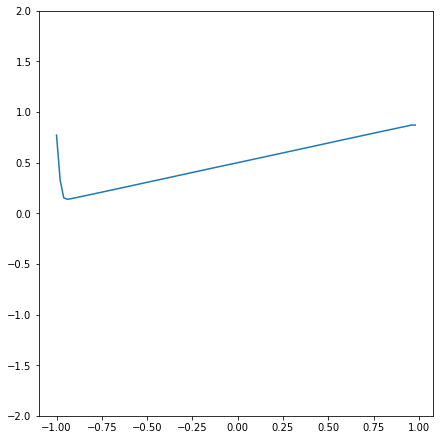

In [36]:
# Visualizando os resultados

Δx = 0.02                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional


# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres))

u = f_test(x) # Obtendo a condição inicial a partir de f_test
#-------------------------------------------------------------------------------------------

# Condição inicial fixada
#----------------------------------------------------------------------
# k1 = 5    # Frequência para a função seno
# k2 = 2    # Frequência para a função seno
# a  = 0.25 # Peso para ponderar as funções seno
# b  = 0.75 # Modificador de amplitude

# # Função que gera pontos de acordo com a primeira função seno
# u1 = lambda x:     a * tf.expand_dims(tf.math.sin(k1*pi*x), axis=1)
# # Função que gera pontos de acordo com a segunda função seno
# u2 = lambda x: (1-a) * tf.expand_dims(tf.math.sin(k2*pi*x), axis=1)
# # Obtendo a condição inicial a partir das funções senos
# u  = b*(u1(x)+u2(x))
#-----------------------------------------------------------------------

u   = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão
u_Z = u[:]                      # u do artigo

u=tf.expand_dims(u,axis=0)
u_Z=tf.expand_dims(u[:],axis=2)
u=tf.transpose(u,[0,2,1])
u_Z = u[:]

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T = 2     # Instante de tempo final
t = 0.0   # Instante de tempo inicial

# Gerando os gráficos a partir de funções do matplotlib

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)
# ax.set_xlim(0,1)
line = ax.plot(x, tf.squeeze(u))
hfig = display(fig, display_id=True)

while t < T:
    
    Δt_max = T-t # Tempo restante até T
    
    # Valor utilizado para obter o Δt
    Λ  = tf.math.reduce_max(tf.abs(u), keepdims=True)
    # Obtendo o valor de Δt a partir de CFL
    Δt = Δx*CFL/Λ
    # Caso o passo temporal utrapasse o valor de Δt_max então o 
    # tamanho do passo se torna Δt_max
    Δt = tf.where(Δt > Δt_max, Δt_max, Δt)
    
    final_layer.t_final.assign(tf.cast(tf.squeeze(Δt), dtype=float_pres)) # Definindo um passo de tamanho Δt
    u          = Network.predict(u)                                       # Saída da rede neural
    squeezed_u = tf.squeeze(u)                                            # Reduzindo dimensões redundantes
    
    t += Δt # Avançando no tempo
    
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')
    
    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u.numpy())
    fig.canvas.draw()
    hfig.update(fig)
    
print('\n')
t = tf.zeros([1,1,1],dtype=float_pres)

while t < T:
    
    Δt_max = T-t # Tempo restante até T
    
    # Valor utilizado para obter o Δt
    Λ   = tf.math.reduce_max(tf.abs(u_Z), axis=1, keepdims=True)
    # Obtendo o valor de Δt a partir de CFL
    Δt  = Δx*CFL/Λ
    # Caso o passo temporal utrapasse o valor de Δt_max então o 
    # tamanho do passo se torna Δt_max
    Δt  = tf.where(Δt > Δt_max, Δt_max,Δt)
    
    # Saída de Burgers (aqui costuma-se utilizar a equação do transporte)
    u_Z        = Burgers(u_Z, Δt, Δx, CFL, FronteiraPeriodica) 
    squeezed_u = tf.squeeze(u_Z) # Reduzindo dimensões redundantes
    
    t += Δt # Avançando no tempo
    
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')
    
    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u.numpy())
    fig.canvas.draw()
    hfig.update(fig)


In [12]:
def pega_ponto_Z(indice):
    """
    Função que retorna os pesos calculados pelo WENO-Z a partir de um índice,
    assumindo que existe um tensor u_Z no escopo de memória externo à função
    --------------------------------------------------------------------------
    u_Z (tensor): tensor contendo os estados da função para a qual deseja-se
                  extrair o subestêncil de interesse
    indice (int): índice central do subestêncil utilizado para o cálculo dos
                  pesos
    --------------------------------------------------------------------------
    ω_Z (tensor): pesos obtidos
    --------------------------------------------------------------------------
    """
    ɛ = 10.0**(-40)
    U = u_Z[:,indice-2:indice+3,:] # Seleciona o subestêncil
    
    # Calcula os indicadores de suavidade locais
    u_stacked = tf.transpose(tf.stack([U, U, U], axis=0), [0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A), axis=3)
    β = tf.transpose(β, [1,2,0])
    
    # Calcula o indicador de suavidade global
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    
    # Calcula os pesos do WENO-Z
    α    = (1 + (τ/(β + ɛ))**2) @ B
    soma = tf.math.reduce_sum(α, axis=2, keepdims=True)
    ω_Z  = α / soma
    
    return ω_Z

In [13]:
def pega_ponto_rede(indice):
    """
    Função que retorna os pesos calculados pelo WENO-Z codificados pela rede 
    neural a partir de um índice, assumindo que existe um tensor u no escopo 
    de memória externo à função
    -------------------------------------------------------------------------
    indice    (int): índice central do subestêncil utilizado para o cálculo
                     dos pesos
    u      (tensor): tensor contendo os estados da função para a qual 
                     deseja-se extrair o subestêncil de interesse
    -------------------------------------------------------------------------
    ω_Rede (tensor): pesos obtidos
    -------------------------------------------------------------------------
    """
    ɛ = 10.0**(-40)
    U = u[:,indice-2:indice+3,:] # Seleciona o subestêncil
    
    # Calculando o input para a rede neural
    # Entrada 1: U_{i+1} - U_{i-1}
    # Entrada 2: U_{i+1} - 2*U_{i} + U_{i-1}
    U_diff      = tf.concat([U[:,2:]-U[:,:-2], U[:,2:]-2*U[:,1:-1]+U[:,:-2]], axis=2)
    # Obtendo os modificadores dos pesos executando a rede neural
    beta_weight = tf.transpose(Network.layers[1].network_graph(U_diff), [0,2,1])
    
    # Calcula os indicadores de suavidade locais
    u_stacked = tf.transpose(tf.stack([U,U,U], axis=0), [0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A), axis=3)
    β = tf.transpose(β, [1,2,0])
    
    # Calcula o indicador de suavidade global
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    
    # Calcula os pesos do WENO modificado pelo rede neural
    α      = (1 + (τ/(β + ɛ))**2) @ B
    soma   = tf.math.reduce_sum(α, axis=2, keepdims=True)
    ω_Rede = α / soma
    ω_Rede = (1-beta_weight)*ω_Rede + beta_weight*tf.constant([[[1,6,3]]],dtype=float_pres)/10
    
    return ω_Rede

In [20]:
pega_ponto_Z(indice)

InvalidArgumentError: In[0] mismatch In[1] shape: 4 vs. 5: [3,1,1,4] [3,1,5,5] 0 0 [Op:BatchMatMulV2]

In [28]:
# Código que utiliza as fuções pega_ponto_Z e pega_ponto_rede para salvar os
# pesos gerados por cada uma das versões do WENO de interesse

n_pontos  = 9   # Número de substêncis coletados
mid_point = 6 # Índice do ponto 'central'

y_plot_Rede = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z com rede neural
y_plot_Z    = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z

for i in range(n_pontos):
    
    indice = int(mid_point-(n_pontos-1)/2+i)             # Determinadno o índice para as funções
    y_plot_Z[i]    = np.squeeze(pega_ponto_Z(indice))    # Armazenando os pesos do WENO-Z
    y_plot_Rede[i] = np.squeeze(pega_ponto_rede(indice)) # Armazenando os pesos do WENO-Z com rede neural

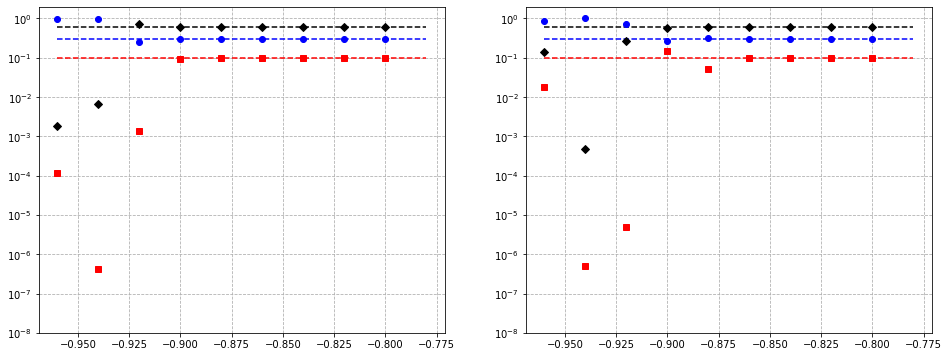

In [29]:
# Código que gera os gráficos comparando os pesos do WENO-Z e os pesos do WENO-Z
# modificados pela rede neural

# Criando os objetos que irão conter os plots
fig, axs = plt.subplots(1, 2, figsize=(8*2, 6))

# Variáveis auxiliares para ajustar os limites dos gráficos
ylim      = (10**-8, 2)
min_x     = int(mid_point-(n_pontos-1)/2)
max_x     = int(mid_point+(n_pontos+1)/2)

# Inserindo os pontos nos gráficos
axs[0].plot(x[min_x:max_x], y_plot_Z[:,0], 's', color='red'  , alpha=1)
axs[0].plot(x[min_x:max_x], y_plot_Z[:,1], 'D', color='black', alpha=1)
axs[0].plot(x[min_x:max_x], y_plot_Z[:,2], 'o', color='blue' , alpha=1)

# Criando as linhas horizontais dos gráficos
axs[0].hlines(
    y          = 1/10,
    xmin       = x[min_x],
    xmax       = x[max_x],
    color      = 'red',
    linestyles = '--'
)
axs[0].hlines(
    y          = 6/10,
    xmin       = x[min_x],
    xmax       = x[max_x],
    color      = 'black',
    linestyles = '--'
)
axs[0].hlines(
    y          = 3/10,
    xmin       = x[min_x],
    xmax       = x[max_x],
    color      = 'blue',
    linestyles = '--'
)

# Configuração de parâmetros gráficos referentes ao eixo y
axs[0].set_yscale('log')
axs[0].set_ylim(*ylim)
axs[0].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[0].grid(ls='--')

# Inserindo os pontos nos gráficos
axs[1].plot(x[min_x:max_x], y_plot_Rede[:,0], 's', color='red',   alpha=1)
axs[1].plot(x[min_x:max_x], y_plot_Rede[:,1], 'D', color='black', alpha=1)
axs[1].plot(x[min_x:max_x], y_plot_Rede[:,2], 'o', color='blue',  alpha=1)

# Criando as linhas horizontais dos gráficos
axs[1].hlines(
    y          = 1/10,
    xmin       = x[min_x],
    xmax       = x[max_x],
    color      = 'red',
    linestyles = '--'
)
axs[1].hlines(
    y          = 6/10,
    xmin       = x[min_x],
    xmax       = x[max_x],
    color      = 'black',
    linestyles = '--'
)
axs[1].hlines(
    y          = 3/10,
    xmin       = x[min_x],
    xmax       = x[max_x],
    color      = 'blue',
    linestyles = '--')

# Configuração de parâmetros gráficos referentes ao eixo y
axs[1].set_yscale('log')
axs[1].set_ylim(*ylim)
axs[1].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[1].grid(ls='--')

# Exibindo os gráficos
plt.show()